In [ ]:
import pandas as pd  
import collections
import numpy as np
from textblob import TextBlob # pip install -U textblob, python -m textblob.download_corpora
from textblob.classifiers import NaiveBayesClassifier
import nltk # pip install nltk, python -m textblob.download_corpora
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline # pip install -q transformers
import matplotlib.pyplot as plt

# making dataframe
df = pd.read_csv("data/sentiment140_with_location.csv", names=['target','id','date','flag','user','text', 'location'])  
df

In [ ]:
# split dataset
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, 8)
split_df = result[0]
split_df

In [ ]:
target_counts = collections.Counter(result[0]['target'])
location_counts = collections.Counter(result[0]['location'])
print("target counts: ", target_counts)
print("location_counts: ", location_counts)

In [ ]:
def locationSentiment(data, location):
    """
    input: location is the input location of interest
    output: the average sentiment of the tweets for a location
    """
    # go through the dataframe filtered by location
    # get the average sentiment of the tweets in that location by getting sum and dividing by number of rows
    location_data = data[data["location"] == location]
    total_sentiment_value = sum(list(location_data["target"]))
    return total_sentiment_value/len(location_data)

def getLocationTweetsWithSentiment(data, location):
    tweets_with_sentiment = []
    location_data = data[data["location"] == location]
    for row in location_data.iterrows():
        sentiment = row[1]['target']
        text = row[1]['text']
        sentiment_for_classifier = ""
        if sentiment == 0:
            # negative
            sentiment_for_classifier = "neg"
        elif sentiment == 4:
            # positive
            sentiment_for_classifier = "pos"
        tweets_with_sentiment.append((text,sentiment_for_classifier))
    return tweets_with_sentiment

# print(locationSentiment(result[0], "China"))
tweets = getLocationTweetsWithSentiment(result[0], "China")
print(tweets)


In [ ]:
# find average sentiment for each location and store in location_scores
location_scores = {}

for (location, count) in location_counts.items():
    score = locationSentiment(result[0], location)
    location_scores[location] = score

# code sourced from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
sorted_location_scores = {k: v for k, v in sorted(location_scores.items(), key=lambda item: item[1])}
sorted_location_scores

In [ ]:
# drop unnecessary columns
split_df = split_df.drop(['id', 'date', 'flag', 'user'], axis=1)

split_df

In [ ]:
dataset = getLocationTweetsWithSentiment(result[0], "USA")
train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
test = dataset[int(0.8*len(dataset)):]

In [ ]:
# Naive Bayes Classifier
cl = NaiveBayesClassifier(train) # train needs tuples of text and pos/neg
correct = 0
for text, sentiment in test:
    pred = cl.classify(text)
    correct += (pred == sentiment)
print(correct/len(test))


In [ ]:
# nltk sentiment intensity analyzer model
# 51% accuracy

sia = SentimentIntensityAnalyzer()
correct = 0
neu_count = 0
for text, sentiment in test:
    sia_pred = sia.polarity_scores(text)
    if sia_pred["compound"] < 0:
        pred = "neg"
    elif sia_pred["compound"] > 0:
        pred = "pos"
    else:
        pred = "neu"
        neu_count += 1
    correct += (pred == sentiment)

print("accuracy:", correct/len(test))
print("neu %:", neu_count/len(test))


In [ ]:
# this takes a while to run (took 3 min for me)

# hugging face transformer model
# 50% accuracy
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

correct = 0
data = [text for text, sentiment in test]

results = specific_model(data)

print(results)

In [20]:
# calculations for above model
correct = 0
# neu_count = 0
for i in range(len(results)):
    label = results[i]['label'].lower()
    sentiment = test[i][1]
    if label == 'neu':
        # neu_count += 1
        label = "pos"
    correct += (label == sentiment)

print("accuracy:", correct/len(test))
# print("neu %:", neu_count/len(test))

accuracy: 0.71875


things to note about dataset:
- no "0" or "neutral" labels



data clean up:

- remove links from tweets, something like:
tweets = [t.replace("://", "//") for t in nltk.corpus.twitter_samples.strings()]

- remove tweets that don't have a location


TODO: 
* Location sentiment scores
* bar graphs for sentiment by location


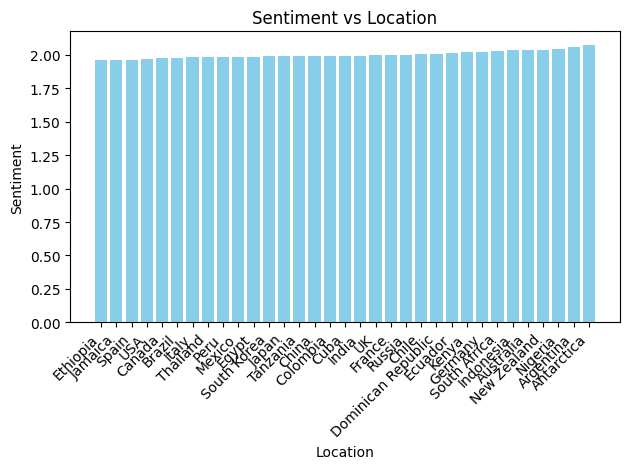

In [15]:
def plot_bar_graph(locations_with_sentiments):
    """
    input: locations with sentiments is a dictionary with the keys being the locations and the values is the sentiment
    """
    locations_list = (list(locations_with_sentiments.keys()))
    # sentiment_list = list(locations_with_sentiments.values())
    sentiment_list = list(locations_with_sentiments.values())

    # Plotting
    plt.bar(locations_list, sentiment_list, color='skyblue')
    plt.xlabel('Location')
    plt.ylabel('Sentiment')
    plt.title('Sentiment vs Location')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# sorted_location_scores

plot_bar_graph(sorted_location_scores)

In [23]:
# only done for naive bayes so far
def averageSentimentByLocation(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
    test = dataset[int(0.8*len(dataset)):]
    # naive bayes
    naive_bayes = NaiveBayesClassifier(train)
    total_sentiment = 0
    true_sentiment = 0
    for text, sentiment in test:
        pred = naive_bayes.classify(text)
        if sentiment == "pos":
            true_sentiment += 4
        if pred == "pos":
            total_sentiment += 4
        if pred == "neu":
            total_sentiment += 2
        # negative is still just value 0
    average_sentiment = total_sentiment/len(test)
    average_true = true_sentiment/len(test)
    print("average true sentiment ", average_true)
    return average_sentiment
    
# averageSentimentByLocation('China')

In [ ]:
import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon","punkt",])

[nltk_data] <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED]
[nltk_data]     certificate verify failed: unable to get local issuer
[nltk_data]     certificate (_ssl.c:997)>


False

In [25]:
# SentimentIntensityAnalyzer (pre-trained)
def averageSentimentByLocation_sia(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    test = dataset[int(0.8*len(dataset)):]
    sia = SentimentIntensityAnalyzer()
    total_sentiment = 0
    # using test so we can compare scores across models
    for text, _ in test:
        sia_pred = sia.polarity_scores(text)
        if sia_pred["compound"] > 0:
            total_sentiment += 4
        elif sia_pred["compound"] == 0:
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

# averageSentimentByLocation_sia('China')
    

In [24]:
# hugging face transformer model (pre-trained)
def averageSentimentByLocation_hf(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
    # note: model can only take 204 or 128 items in dataset, so only using test
    data = [text for text, sentiment in test]
    results = specific_model(data)

    print(results)
    total_sentiment = 0
    for r in results:
        label = r['label'].lower()
        if label == 'pos':
            total_sentiment += 4
        if label == 'neu':
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

# averageSentimentByLocation_hf('China')

average true sentiment  2.004954582989265


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

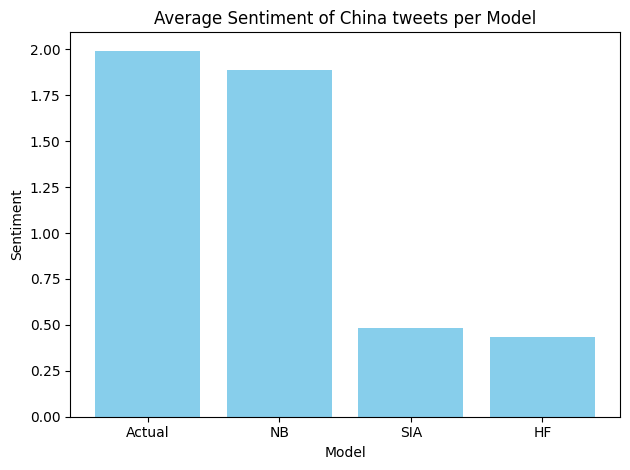

In [19]:
def plotBarGraph_locSent(location, original_sentiments):
    """
    input: location of interest
    """
    true_sentiment = original_sentiments[location]
    nb_sentiment = averageSentimentByLocation(location)
    sia_sentiment = averageSentimentByLocation_sia(location)
    hf_sentiment = averageSentimentByLocation_hf(location)

    model_names = ["Actual", "NB", "SIA", "HF"] # add this in "Sentiment Intensity Analyzer"
    sentiment_values = [true_sentiment, nb_sentiment, sia_sentiment, hf_sentiment] # add this in sia_sentiment 
    # Plotting
    plt.bar(model_names, sentiment_values, color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Sentiment')
    plt.title(f'Average Sentiment of {location} tweets per Model')
    # plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

plotBarGraph_locSent("China", sorted_location_scores)

average true sentiment  2.031905961376994


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

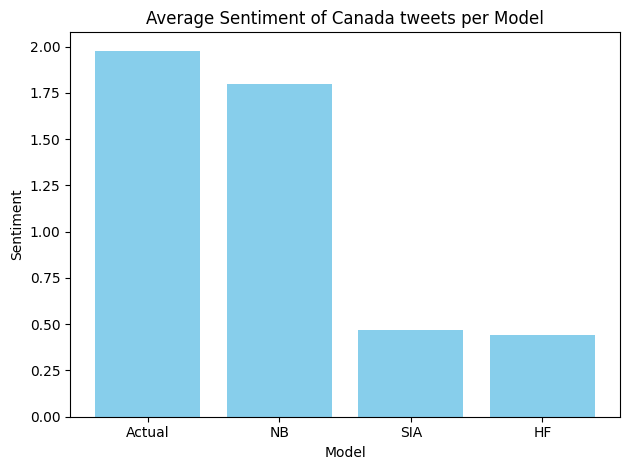

In [20]:
plotBarGraph_locSent("Canada", sorted_location_scores)

average true sentiment  1.9170056956875507


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

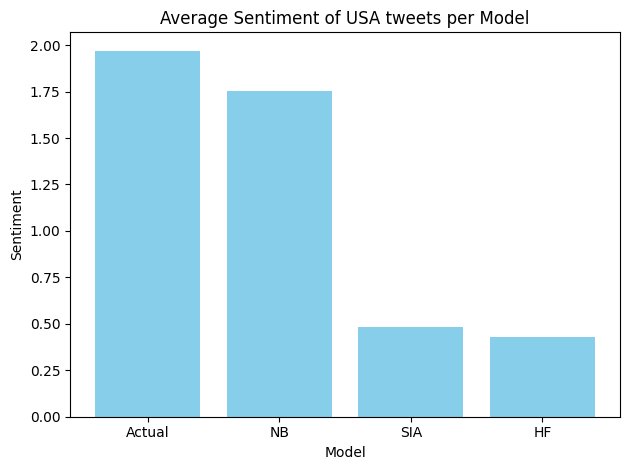

In [21]:
plotBarGraph_locSent("USA", sorted_location_scores)

average true sentiment  1.981651376146789


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

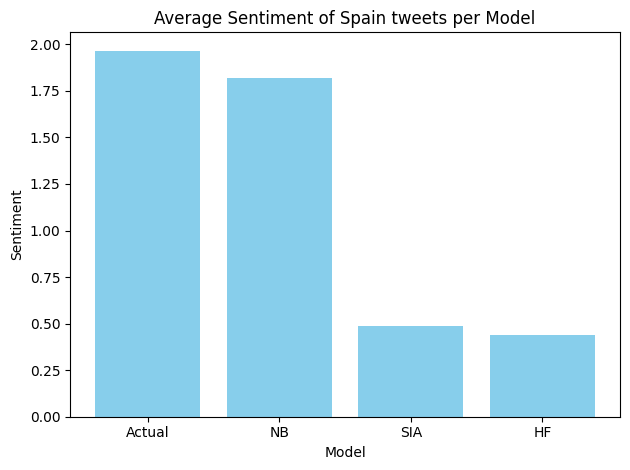

In [22]:
plotBarGraph_locSent("Spain", sorted_location_scores)

In [27]:
all_location_counts = collections.Counter(df['location'])
all_location_counts.total()

1600000

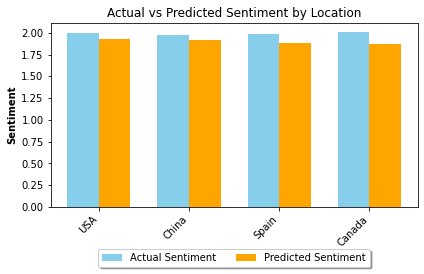

In [32]:
def plot_grouped_bar(locations, actual_sentiments, predicted_sentiments):
    actual_sentiments_list = list(actual_sentiments.values())
    predicted_sentiments_list = list(predicted_sentiments.values())

    # Set the width of the bars
    bar_width = 0.35

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(locations))
    r2 = [x + bar_width for x in r1]

    # Plotting
    plt.bar(r1, actual_sentiments_list, color='skyblue', width=bar_width, label='Actual Sentiment')
    plt.bar(r2, predicted_sentiments_list, color='orange', width=bar_width, label='Predicted Sentiment')

    # Add xticks on the middle of the group bars
    plt.xlabel('Location', fontweight='bold')
    plt.ylabel('Sentiment', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(locations))], locations, rotation=45, ha='right')

    # Create legend & Show graphic
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)
    plt.title('Actual vs Predicted Sentiment by Location')
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


predicted_sentiments
actual_sentiments
plot_grouped_bar(locations, actual_sentiments, predicted_sentiments)

In [ ]:
locations = ["USA", "China", "Spain", "Canada"]
actual_sentiments = {
    'USA': sorted_location_scores["USA"],
    'China': sorted_location_scores["China"],
    'Spain': sorted_location_scores["Spain"],
    'Canada': sorted_location_scores["Canada"]}

predicted_sentiments = {
    'USA': averageSentimentByLocation("USA"),
    'China': averageSentimentByLocation("China"),
    'Spain': averageSentimentByLocation("Spain"),
    'Canada': averageSentimentByLocation("Canada")
}
plot_grouped_bar(locations, actual_sentiments, predicted_sentiments)